# Setup

In [4]:
jsoc_email = "David.boils488@topper.wku.edu"

In [5]:
%matplotlib inline

import torch

import sunpy

import aiapy
import aiapy.data.sample as sample_data
from aiapy.calibrate import normalize_exposure, register, update_pointing

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np

import scipy

# Set default fig size for matplotlib
plt.rcParams['figure.figsize'] = [8, 8]

from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries

import datetime

#import ffmpeg

# Flare Confirmation

In [6]:
# Only give me GOES>=C1.0 flares
results = Fido.search(a.Time('2022-01-25', '2022-01-26'), a.hek.FL, a.hek.FL.GOESCls > "C1.0")

results.show()

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs [8]
str131,str1,str115,str5,str18,str12,object,str28,object,str130,object,str57,str41,str19,str1,str2,object,object,float64,str82,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str75,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str18,str1,object,object,str17,object,str9,str3,str1,int32,str1,int32,str5,str110,str1,str1,str1,object,str99,str20,object,object,object,str1,str1,str1,int32,object,str19,str7,float64,float64,str3,object,str19,str14,object,str1,str1,object,str1,str1,str2,str62,str17,int32,int32,object,int32,str1,str1,object,str5,int32,float64,object,int32,str1,str1,int32,str4,str1,str1,str3,int32,str1,str19,str19,object,int32,object,int32,str3,object,str5,str1,str1,object,float64,float64,str19,int32,str1,str4,str13,str1,object,object,str1,str1,object,str1,str19,object,str30,str1,str1,object
http://sdowww.lmsal.com/sdomedia/ssw/media/ssw/ssw_client/data/ssw_service_220124_221106_31268/www/ssw_cutout_193_context_thumb.gif,0,"POLYGON((17.077996 110.39256,17.077996 110.39256,17.077996 110.39256,17.077996 110.39256,17.077996 110.39256))",false,POINT(96.50562 17),UTC-HGS-TOPO,None,POINT(-930.35364 288.183192),None,http://sdowww.lmsal.com/sdomedia/ssw/media/ssw/ssw_client/data/ssw_service_220124_221106_31268/www/ssw_cutout_193_context_full.gif,None,"AIA20220125_053400_0094.fits,AIA20220125_055400_0094.fits",POINT(0.9998645701236 72.7892871310252),2022-01-25T05:34:00,,FL,None,None,9.4e-07,http://sohowww.nascom.nasa.gov/solarsoft/packages/gevloc/idl/ssw_flare_locator.pro,,,false,,true,None,None,,,None,,0103000000010000000500000075543541D4048EC0390EBC5AEE1E704075543541D4048EC0390EBC5AEEE6734075543541D4208CC0390EBC5AEEE6734075543541D4208CC0390EBC5AEE1E704075543541D4048EC0390EBC5AEE1E7040,"POLYGON((-175.49438 1,-175.49438 1,-175.49438 1,-175.49438 1,-175.49438 1))",None,,EUV,,,SOL2022-01-25T05:34:00L096C073,None,9,,,,Samuel L. Freeland,,None,None,SSW Latest Events,None,SolarSoft,SDO,,18,,16,LMSAL,"POLYGON((0.114676 351.205918,0.114676 351.205918,0.114676 351.205918,0.114676 351.205918,0.114676 351.205918))",,,,None,http://sdowww.lmsal.com/sdomedia/ssw/media/ssw/ssw_cli

In [7]:
hek_results = results['hek']
print(hek_results["event_starttime"])
print(hek_results["event_peaktime"])
print(hek_results["event_endtime"])
print(hek_results["fl_goescls"])

  event_starttime  
-------------------
2022-01-25T05:34:00
2022-01-25T10:21:00
2022-01-25T22:38:00
2022-01-25T23:38:00
   event_peaktime  
-------------------
2022-01-25T05:53:00
2022-01-25T10:29:00
2022-01-25T22:44:00
2022-01-25T23:49:00
   event_endtime   
-------------------
2022-01-25T06:05:00
2022-01-25T10:36:00
2022-01-25T22:48:00
2022-01-25T23:54:00
fl_goescls
----------
      C2.1
      C3.7
      C2.1
      C9.9


In [8]:
# Pick a flare!
my_flare = hek_results[3]

# Look for GOES data during this time
results = Fido.search(a.Time(my_flare["event_starttime"], my_flare["event_endtime"]), a.Instrument.xrs)

results.show()

C:\Users\jboil\anaconda3\envs\SolarFlare\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Start Time,End Time,Instrument,SatelliteNumber,Physobs,url,Source,Provider
Time,Time,str3,int32,str10,str161,str4,str4
2022-01-25 00:00:00.000,2022-01-25 23:59:59.999,XRS,16,irradiance,https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-flx1s_science/2022/01/sci_xrsf-l2-flx1s_g16_d20220125_v2-1-0.nc,GOES,NOAA
2022-01-25 00:00:00.000,2022-01-25 23:59:59.999,XRS,17,irradiance,https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes17/l2/data/xrsf-l2-flx1s_science/2022/01/sci_xrsf-l2-flx1s_g17_d20220125_v2-1-0.nc,GOES,NOAA


In [9]:
goes_files = Fido.fetch(results)

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  9.75file/s]


In [10]:
# Filter the timeseries to find one that spans the whole day

timeseries = TimeSeries(goes_files)

for series in timeseries:
    if not series.to_dataframe().isnull().values.any():
        goes = series

<AxesSubplot:ylabel='Watts m$^{-2}$'>

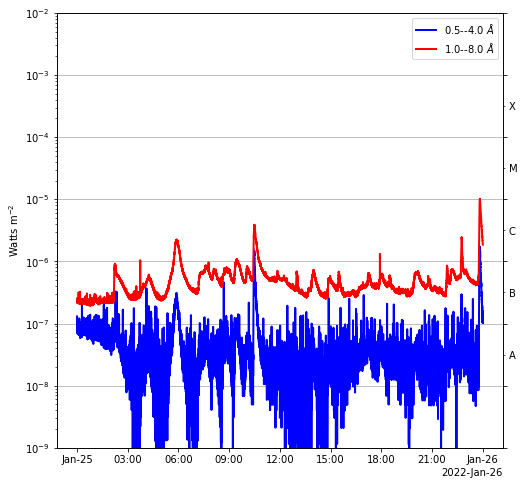

In [11]:
goes.plot()

Now that we have picked our flare and have our GOES data for during that time frame, let's get started on visualization

In [12]:
# Find the flare image at peak time
results = Fido.search(a.Time(my_flare["event_peaktime"], my_flare["event_peaktime"]),
                      a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'))
results.show()

T_REC,T_OBS,WAVELNTH,DATE,FSN,EXPTIME,QUALITY,ORIGIN,TELESCOP,INSTRUME,DATE__OBS,DATE-OBS,CAMERA,IMG_TYPE,EXPSDEV,INT_TIME,WAVEUNIT,WAVE_STR,FID,QUALLEV0,TOTVALS,DATAVALS,MISSVALS,PERCENTD,DATAMIN,DATAMAX,DATAMEDN,DATAMEAN,DATARMS,DATASKEW,DATAKURT,DATACENT,DATAP01,DATAP10,DATAP25,DATAP75,DATAP90,DATAP95,DATAP98,DATAP99,NSATPIX,OSCNMEAN,OSCNRMS,FLAT_REC,NSPIKES,CTYPE1,CUNIT1,CRVAL1,CDELT1,CRPIX1,CTYPE2,CUNIT2,CRVAL2,CDELT2,CRPIX2,CROTA2,R_SUN,MPO_REC,INST_ROT,IMSCL_MP,X0_MP,Y0_MP,ASD_REC,SAT_Y0,SAT_Z0,SAT_ROT,ACS_MODE,ACS_ECLP,ACS_SUNP,ACS_SAFE,ACS_CGT,ORB_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS,GAEX_OBS,GAEY_OBS,GAEZ_OBS,HAEX_OBS,HAEY_OBS,HAEZ_OBS,OBS_VR,OBS_VW,OBS_VN,CAR_ROT,CRLT_OBS,CRLN_OBS,HGLN_OBS,HGLT_OBS,ROI_NWIN,CALVER32,ROI_SUM,ROI_NAX1,ROI_NAY1,ROI_LLX1,ROI_LLY1,ROI_NAX2,ROI_NAY2,ROI_LLX2,ROI_LLY2,PIXLUNIT,DN_GAIN,EFF_AREA,EFF_AR_V,TEMPCCD,TEMPGT,TEMPSMIR,TEMPFPAD,ISPSNAME,ISPPKTIM,ISPPKTVN,AIVNMST,AIMGOTS,ASQHDR,ASQTNUM,ASQFSN,AIAHFSN,AECDELAY,AIAECTI,AIASEN,AIFDBID,AIMGOTSS,AIFCPS,AIFTSWTH,AIFRMLID,AIFTSID,AIHISMXB,AIHIS192,AIHIS348,AIHIS604,AIHIS860,AIFWEN,AIMGSHCE,AECTYPE,AECMODE,AISTATE,AIAECENF,AIFILTYP,AIMSHOBC,AIMSHOBE,AIMSHOTC,AIMSHOTE,AIMSHCBC,AIMSHCBE,AIMSHCTC,AIMSHCTE,AICFGDL1,AICFGDL2,AICFGDL3,AICFGDL4,AIFOENFL,AIMGFSN,AIMGTYP,AIAWVLEN,AIAGP1,AIAGP2,AIAGP3,AIAGP4,AIAGP5,AIAGP6,AIAGP7,AIAGP8,AIAGP9,AIAGP10,AGT1SVY,AGT1SVZ,AGT2SVY,AGT2SVZ,AGT3SVY,AGT3SVZ,AGT4SVY,AGT4SVZ,AIMGSHEN,KEYWDDOC,LVL_NUM,T_REC_step,T_REC_epoch
str20,str23,int64,str20,int64,float64,int64,str12,str7,str5,str23,str23,int64,str5,float64,float64,str8,str8,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str20,int64,str8,str6,float64,float64,float64,str8,str6,float64,float64,float64,float64,float64,str30,float64,float64,float64,float64,str29,float64,float64,float64,str7,str2,str3,str2,str3,str46,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str17,str23,str7,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str2,str6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str74,float64,float64,str23
2022-01-25T23:48:59Z,2022-01-25T23:49:00.57Z,94,2022-01-31T15:10:57Z,249581733,2.900808,0,SDO/JSOC-SDP,SDO/AIA,AIA_4,2022-01-25T23:48:59.12Z,2022-01-25T23:48:59.12Z,4,LIGHT,0.000172,3.164062,angstrom,94_THIN,0,0,16777216,16777216,0,100.0,-8,11787,1,1.9835,9.35,714.62,696807.62,1.67,-1.0,0.0,1.0,4.0,6.0,7.0,11.0,14.0,0,--,--,aia.flatfield[:#639],38223,HPLN-TAN,arcsec,0.0,0.600109,2071.042969,HPLT-TAN,arcsec,0.0,0.600109,2008.066895,-0.137709,1624.416382,aia.master_pointing3h[:#46570],-0.13761,0.600109,2070.042969,2007.066895,sdo.lev0_asd_0004[:#94558111],-3.029412,10.464299,-9.9e-05,SCIENCE,NO,YES,NO,GT3,sdo.fds_orbit_vectors[2022.01.25_23:49:00_UTC],149597870691.0,147268037629.48,696000000.0,974.826866,33823577.99,2387303.72,-25057976.4,-85879740922.42,119635045322.48,-30610824.77,2954.348195,29379.561934,-3587.824128,2253,-5.552417,173.424606,-0.01199,-5.552417,--,--,--,--,--,--,--,--,--,--,--,DN,18.3,0.282,3.0,-71.0,21.01,41.23,21.063,aia.lev0_isp_0011,2022-01-25T23:48:57.51Z,001.197,453,2021845777,3470807205,3,249581733,249581725,1535,0,0,241,12964,4,0,3338,40961,7,0,8345844,8386158,8388608,270,2900,2,ON,CLOSED,1,0,40.472,25.375999,54.287998,67.800003,2940.991943,2926.219971,2955.184082,2968.771973,0,23,87,236,1,7,0,9,0,0,0,0,0,0,0,279,343,748,-6,-9,-12,-16,-2,0,56,122,4,https://www.lmsal.com/sdodocs/doc

In [13]:
# Fetch the one image
downloaded_files = Fido.fetch(results)

Export request pending. [id=JSOC_20220417_966, status=2]
Waiting for 0 seconds...
INFO: max_splits keyword was passed and set to 1. [sunpy.net.jsoc.jsoc]
14 URLs found for download. Full request totalling 70MB


Files Downloaded: 100%|██████████| 14/14 [00:02<00:00,  5.93file/s]


In [14]:
# Given a filename in the standard format from JSOC download, find out what the wavelength is
def WavelengthFromFilename(filename):
    # Position of "." after wavelength
    end = filename.find(".image")
    if end < 0:
        return -1
    
    start = end - 1
    
    while filename[start] != '.':
        start = start - 1
    
    start = start + 1
    
    return int(filename[start:end])

# Given a filename in the standard format from JSOC download, find out what the time is
def TimeFromFilename(filename):
    start = filename.find("euv_12s")
    if start < 0:
        return -1
    start = start + 8
    
    end = start + 1
    
    while filename[end] != '.':
        end = end + 1
    
    end = end - 1
    
    return filename[start:end]

# Order of wavelengths from low to high temperature
wavelengthIndexDict = {304:0, 131:1, 171:2, 193:3, 211:4, 335:5, 94:6}

# And the inverse
wavelengthInvIndexDict = {v: k for k, v in wavelengthIndexDict.items()}

In [15]:
binnedFiles = [[], [], [], [], [], [], []]

for file in downloaded_files:
    wav = WavelengthFromFilename(file)
    
    # skip if it is a spike file
    if wav == -1:
        continue
    
    # otherwise bin it
    binnedFiles[wavelengthIndexDict[wav]].append(file)

In [16]:
# Now also sort each bin by time

for wav_bin in binnedFiles:
    wav_bin.sort()

C:\Users\jboil\AppData\Local\Temp/ipykernel_10908/1051303991.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Shape (y, x):  (240, 71)


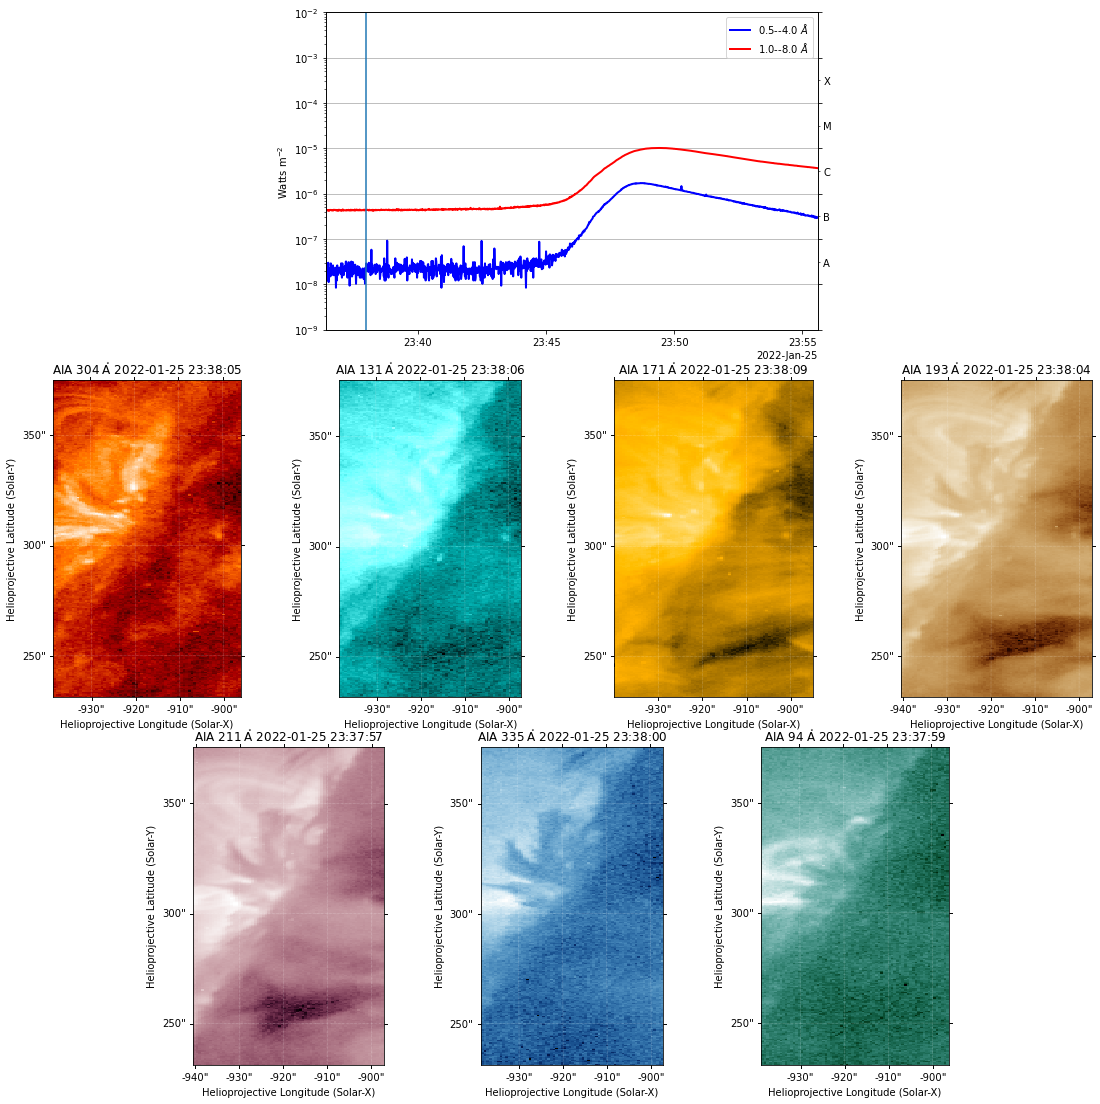

In [70]:
# Visualize the event to confirm the bounding box is fine

# TWEAK THESE:
bbox_add_left_deg = 10
bbox_add_right_deg = 10
bbox_add_up_deg = 30
bbox_add_down_deg = 30

event_start = datetime.datetime.strptime(my_flare['event_starttime'], "%Y-%m-%dT%H:%M:%S")
event_end = datetime.datetime.strptime(my_flare['event_endtime'], "%Y-%m-%dT%H:%M:%S")
event_length = event_end - event_start

top_right = SkyCoord(my_flare["boundbox_c1ur"] + bbox_add_right_deg , my_flare["boundbox_c2ur"] + bbox_add_up_deg, unit="deg", frame=sunpy.coordinates.frames.HeliographicStonyhurst)
bottom_left = SkyCoord(my_flare["boundbox_c1ll"] - bbox_add_left_deg, my_flare["boundbox_c2ll"] - bbox_add_down_deg, unit="deg", frame=sunpy.coordinates.frames.HeliographicStonyhurst)

mymaps = sunpy.map.Map([f[0] for f in binnedFiles])

submaps = [mymap.submap(bottom_left, top_right=top_right) for mymap in mymaps]

idx_time = datetime.datetime.strptime(TimeFromFilename(binnedFiles[0][0]), "%Y-%m-%dT%H%M%S")

fig, ax = plt.subplots(figsize=(15,15))

axg = plt.subplot2grid((3,8), (0,2), colspan=4)
ax1 = plt.subplot2grid((3,8), (1,0), colspan=2, projection=submaps[0])
ax2 = plt.subplot2grid((3,8), (1,2), colspan=2, projection=submaps[1])
ax3 = plt.subplot2grid((3,8), (1,4), colspan=2, projection=submaps[2])
ax4 = plt.subplot2grid((3,8), (1,6), colspan=2, projection=submaps[3])
ax5 = plt.subplot2grid((3,8), (2,1), colspan=2, projection=submaps[4])
ax6 = plt.subplot2grid((3,8), (2,3), colspan=2, projection=submaps[5])
ax7 = plt.subplot2grid((3,8), (2,5), colspan=2, projection=submaps[6])

axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

gplot = goes.plot(axes=axg)
axg.set_xlim(event_start - 0.1 * event_length, event_end + 0.1 * event_length)
goes_line = axg.axvline(idx_time)

for m_idx, m in enumerate(submaps):
    m.plot(axes=axes_list[m_idx], aspect=0.5)

fig.tight_layout(h_pad=0.05,w_pad=2.5)

fig.show()

print("Shape (y, x): ", submaps[0].data.shape)

Once we have a good bounding box around the flare via the above cell, then we can request only that specific cutout of the sun from JSOC.

# Cutout

In [51]:
print(SkyCoord())

ValueError: Cannot create a SkyCoord without data

In [ ]:
print(submaps[0].bottom_left_coord)

In [71]:
#requesting specific cutouts
cutout = a.jsoc.Cutout(
    submaps[0].bottom_left_coord,
    submaps[0].top_right_coord,
    tracking=True
)
cutout_res = Fido.search(
    a.Time(my_flare["event_starttime"], my_flare["event_endtime"]),
    a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'),
    a.jsoc.Segment.image,
    cutout,
)

cutout_res.show()

T_REC,T_OBS,WAVELNTH,DATE,FSN,EXPTIME,QUALITY,ORIGIN,TELESCOP,INSTRUME,DATE__OBS,DATE-OBS,CAMERA,IMG_TYPE,EXPSDEV,INT_TIME,WAVEUNIT,WAVE_STR,FID,QUALLEV0,TOTVALS,DATAVALS,MISSVALS,PERCENTD,DATAMIN,DATAMAX,DATAMEDN,DATAMEAN,DATARMS,DATASKEW,DATAKURT,DATACENT,DATAP01,DATAP10,DATAP25,DATAP75,DATAP90,DATAP95,DATAP98,DATAP99,NSATPIX,OSCNMEAN,OSCNRMS,FLAT_REC,NSPIKES,CTYPE1,CUNIT1,CRVAL1,CDELT1,CRPIX1,CTYPE2,CUNIT2,CRVAL2,CDELT2,CRPIX2,CROTA2,R_SUN,MPO_REC,INST_ROT,IMSCL_MP,X0_MP,Y0_MP,ASD_REC,SAT_Y0,SAT_Z0,SAT_ROT,ACS_MODE,ACS_ECLP,ACS_SUNP,ACS_SAFE,ACS_CGT,ORB_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS,GAEX_OBS,GAEY_OBS,GAEZ_OBS,HAEX_OBS,HAEY_OBS,HAEZ_OBS,OBS_VR,OBS_VW,OBS_VN,CAR_ROT,CRLT_OBS,CRLN_OBS,HGLN_OBS,HGLT_OBS,ROI_NWIN,CALVER32,ROI_SUM,ROI_NAX1,ROI_NAY1,ROI_LLX1,ROI_LLY1,ROI_NAX2,ROI_NAY2,ROI_LLX2,ROI_LLY2,PIXLUNIT,DN_GAIN,EFF_AREA,EFF_AR_V,TEMPCCD,TEMPGT,TEMPSMIR,TEMPFPAD,ISPSNAME,ISPPKTIM,ISPPKTVN,AIVNMST,AIMGOTS,ASQHDR,ASQTNUM,ASQFSN,AIAHFSN,AECDELAY,AIAECTI,AIASEN,AIFDBID,AIMGOTSS,AIFCPS,AIFTSWTH,AIFRMLID,AIFTSID,AIHISMXB,AIHIS192,AIHIS348,AIHIS604,AIHIS860,AIFWEN,AIMGSHCE,AECTYPE,AECMODE,AISTATE,AIAECENF,AIFILTYP,AIMSHOBC,AIMSHOBE,AIMSHOTC,AIMSHOTE,AIMSHCBC,AIMSHCBE,AIMSHCTC,AIMSHCTE,AICFGDL1,AICFGDL2,AICFGDL3,AICFGDL4,AIFOENFL,AIMGFSN,AIMGTYP,AIAWVLEN,AIAGP1,AIAGP2,AIAGP3,AIAGP4,AIAGP5,AIAGP6,AIAGP7,AIAGP8,AIAGP9,AIAGP10,AGT1SVY,AGT1SVZ,AGT2SVY,AGT2SVZ,AGT3SVY,AGT3SVZ,AGT4SVY,AGT4SVZ,AIMGSHEN,KEYWDDOC,LVL_NUM,T_REC_step,T_REC_epoch
str20,str23,int64,str20,int64,float64,int64,str12,str7,str5,str23,str23,int64,str5,float64,float64,str8,str8,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str20,int64,str8,str6,float64,float64,float64,str8,str6,float64,float64,float64,float64,float64,str30,float64,float64,float64,float64,str29,float64,float64,float64,str7,str2,str3,str2,str3,str46,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str17,str23,str7,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str2,str6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str74,float64,float64,str23
2022-01-25T23:37:59Z,2022-01-25T23:38:00.59Z,94,2022-01-31T15:10:55Z,249581293,2.900813,0,SDO/JSOC-SDP,SDO/AIA,AIA_4,2022-01-25T23:37:59.14Z,2022-01-25T23:37:59.14Z,4,LIGHT,0.000173,3.148438,angstrom,94_THIN,0,0,16777216,16777216,0,100.0,-8,500,1,1.9479,3.45,14.55,607.44,1.62,-1.0,0.0,1.0,4.0,6.0,7.0,10.0,14.0,0,--,--,aia.flatfield[:#639],31110,HPLN-TAN,arcsec,0.0,0.600109,2071.042969,HPLT-TAN,arcsec,0.0,0.600109,2008.066895,-0.137483,1624.437744,aia.master_pointing3h[:#46570],-0.13761,0.600109,2070.042969,2007.066895,sdo.lev0_asd_0004[:#94557946],3.55771,10.591439,0.000127,SCIENCE,NO,YES,NO,GT3,sdo.fds_orbit_vectors[2022.01.25_23:38:00_UTC],149597870691.0,147266109058.87,696000000.0,974.839632,34483430.2,646489.43,-24250676.32,-85862786433.27,119644840653.17,-29804890.09,2888.902257,29272.634443,-3666.321146,2253,-5.551485,173.525391,-0.01178,-5.551485,--,--,--,--,--,--,--,--,--,--,--,DN,18.3,0.282,3.0,-71.0,21.013,41.23,21.066,aia.lev0_isp_0011,2022-01-25T23:37:57.51Z,001.197,453,2021845117,3470806765,3,249581293,249581285,1536,0,0,241,14026,4,0,3337,40960,7,0,8350557,8386705,8388608,270,2900,0,ON,CLOSED,1,0,40.467999,25.368,54.279999,67.795998,2940.991943,2926.219971,2955.179932,2968.771973,0,25,89,236,1,7,0,9,0,0,0,0,0,0,0,281,345,748,-4,-10,-10,-16,-1,0,57,122,4,https://www.lmsal.com/sdodocs/doc?cmd=dc

# Datacube Creation

In [72]:
# Fetch the cutouts
cutout_downloaded_files = Fido.fetch(cutout_res)

Export request pending. [id=JSOC_20220418_208, status=2]
Waiting for 0 seconds...
INFO: max_splits keyword was passed and set to 1. [sunpy.net.jsoc.jsoc]
567 URLs found for download. Full request totalling 21MB


Files Downloaded: 100%|█████████▉| 565/567 [02:48<00:00,  3.34file/s]


In [73]:
cutout_downloaded_files.errors

[error(filepath_partial=<function Downloader.enqueue_file.<locals>.filepath at 0x000002514AAD03A0>, url='http://jsoc.stanford.edu/SUM39/D1505198009/S00000/aia.lev1_euv_12s.2022-01-25T234559Z.193.image.fits', exception=ClientConnectorError(ConnectionKey(host='jsoc.stanford.edu', port=80, is_ssl=False, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=3070688949306507280), TimeoutError(10060, "Connect call failed ('171.64.103.244', 80)"))),
 error(filepath_partial=<function Downloader.enqueue_file.<locals>.filepath at 0x000002514A07FB80>, url='http://jsoc.stanford.edu/SUM39/D1505198009/S00000/aia.lev1_euv_12s.2022-01-25T235159Z.193.image.fits', exception=ClientConnectorError(ConnectionKey(host='jsoc.stanford.edu', port=80, is_ssl=False, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=3070688949306507280), TimeoutError(10060, "Connect call failed ('171.64.103.244', 80)")))]

In [59]:
cutout_downloaded_files.data

['C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234347Z.304.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234511Z.94.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234347Z.335.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234511Z.131.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234359Z.94.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234359Z.131.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234523Z.304.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T233811Z.131.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234523Z.335.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234359Z.171.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-01-25T234359Z.193.image.fits',
 'C:\\Users\\jboil\\sunpy\\data\\aia.lev1_euv_12s.2022-0

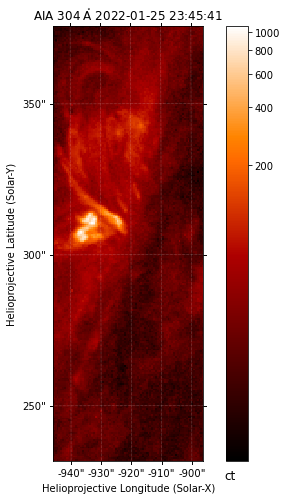

In [60]:
# Read in our downloaded image
m = sunpy.map.Map(cutout_downloaded_files.data[20])

# Derotate and scale, then normalize
#m = normalize_exposure(register(m))

# View it
m.peek()

In [63]:
binnedFiles = [[], [], [], [], [], [], []]

for file in cutout_downloaded_files:
    wav = WavelengthFromFilename(file)
    
    # skip if it is a spike file
    if wav == -1:
        continue
    
    # otherwise bin it
    binnedFiles[wavelengthIndexDict[wav]].append(file)
    
# Now also sort each bin by time

for wav_bin in binnedFiles:
    wav_bin.sort()

In [64]:
# Our data is binned by wavelength, then the 2nd axis is time. Flip it so we bin time first

binnedFilesT = np.array(binnedFiles).T

# Figure out the size of the data cube
array_tuple = binnedFilesT.shape
m = sunpy.map.Map(binnedFilesT[0, 0]).data.T.shape
array_tuple = array_tuple + m

# Generate filename as outlined in fileformat.txt

filename = "flare_" + my_flare["event_starttime"].replace(":", "") + '_' + str(array_tuple[0]) + '_' + str(array_tuple[1]) + '_' + str(array_tuple[2]) + '_' + str(array_tuple[3]) + '.fits'

out_arr = np.zeros(array_tuple, dtype=np.int16)

for t_idx, time_bin in enumerate(binnedFilesT):
    for idx, wavelength in enumerate(time_bin):
        m = sunpy.map.Map(wavelength)

        out_arr[t_idx, idx] = m.data.T

astropy.io.fits.writeto(filename, out_arr, overwrite=True)

C:\Users\jboil\AppData\Local\Temp/ipykernel_10908/1852029174.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  binnedFilesT = np.array(binnedFiles).T


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(filename)

# Loading a Datacube

In [ ]:
from ast import literal_eval as make_tuple

def load_datacube(filename):    
    return astropy.io.fits.getdata(filename)

In [ ]:
new_data = load_datacube('C:/Users/jboil/Documents/Physics/Solar Flare/Notebooks/flare_2022-01-25T233800_81_7_83_240.fits')

In [ ]:
# Now we can use list slicing on it.
# This specifically is all the times, the 0th wavelength and 0, 0 pixel from bottom left
# A time series, if you will :)
#new_data[t,lambda,x,y]
new_data[:,0,0,0]